MAIN IMPORTS

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import pickle as pkl
import string
import seaborn as sns
import psycopg2
import dateutil.parser
from time import sleep

import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm as tqdm # Explain loops

from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, WordNetLemmatizer, PorterStemmer, pos_tag, RegexpParser
from wordcloud import WordCloud
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
wn = WordNetLemmatizer()
ps = PorterStemmer()
stopwords = stopwords.words('english')

from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package stopwords to C:\Users\Intel PC
[nltk_data]     G5900\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Intel PC
[nltk_data]     G5900\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Intel PC G5900\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


SCRAPER URL LIST

In [ ]:
with open("../files/url_list.txt", "r") as f:
    text = f.read()

check_urls = text.splitlines()

In [ ]:
url_list = []
main_link = "https://news.un.org/"
file_path = "../files/url_list.txt"
max_page = 200

for pg in range(max_page):
    url = "https://news.un.org/en/news/topic/climate-change?page="+ str(pg)
    print(url)

    response = requests.get(url, timeout= 25)
    sleep(np.random.uniform(3,4))
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        h2_list = list(soup.find_all('h2', class_ = 'node__title'))

        for h2 in h2_list:
            try:
                href = h2.find('a').get('href')
                url_list.append(main_link + href)
            except:
                print('href not found.')
    else:
        print("Response code not 200.")

with open(file_path, "a") as f:
    for item in url_list:
        if item not in check_urls:
            f.write(str(item) + "\n")

SCRAPER MAIN INFO

In [ ]:
with open("../files/url_list.txt", "r") as f:
    text = f.read()

urls = text.splitlines()

#df= pd.read_csv('../files/articles.csv')
df = pd.DataFrame()
counter = 0

for url in urls:
    print(counter, url)
    try:
        response = requests.get(url, timeout= 25)
        sleep(np.random.uniform(3,4))
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            try:
                title = soup.find('h1').find('span', class_ = "field field--name-title field--type-string field--label-hidden").text
            except:
                title = np.nan

            try:    
                date = soup.find_all('span', class_ = "views-field views-field-field-news-date")[0].find('span', class_ = "field-content").find('time', class_ = "datetime").text
            except:
                date = np.nan

            try:
                category = soup.find_all('span', class_ = "views-field views-field-field-news-topics")[0].find('span', class_ = "field-content").text
            except:
                category = np.nan

            try:
                summary = soup.find_all('div', class_ = "views-field views-field-field-news-story-lead")[0].find('p').text
            except:
                summary = np.nan

            try:
                temp_text_div = soup.find_all('div', class_ = "clearfix text-formatted field field--name-field-text-column field--type-text-long field--label-hidden field__item")[0]
                temp_text_p_list = temp_text_div.find_all('p')

                temp_text_list = []
                for p in temp_text_p_list:
                    temp_text_list.append(p.text)

                temp_text = ' \a '.join(temp_text_list).replace("\xa0", "")
            except:
                temp_text = np.nan

            try:
                temp_text_div = soup.find_all('div', class_ = "clearfix text-formatted field field--name-field-text-column field--type-text-long field--label-hidden field__item")[0]
                temp_text_h3_list = temp_text_div.find_all('h3')

                temp_h3_list = []
                for h3 in temp_text_h3_list:
                    temp_h3_list.append(h3.text)

                h3_text = ' \a '.join(temp_h3_list).replace("\xa0", "")
            except:
                h3_text = np.nan
            link = url
            temp_dict = {
                'link' : link,
                'title': title,
                'date' : date,
                'category' : category,
                'summary' : summary,
                'main_text': temp_text,
                'headers' : h3_text
            }
            temp_df = pd.DataFrame(temp_dict.values()).T
            temp_df.columns = temp_dict.keys()
            df = pd.concat([df, temp_df], ignore_index=True)
    except:
        print('Conection Error')
        df.to_csv('../files/articles_V2.csv', index=False)
    counter = counter + 1    
df.to_csv('../files/articles_V2.csv', index=False)  

EDA

In [4]:
df = pd.read_csv("../files/articles.csv")
print(df.shape)
print(df.info())

(1285, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1285 non-null   object
 1   date       1285 non-null   object
 2   category   1285 non-null   object
 3   summary    1283 non-null   object
 4   main_text  1285 non-null   object
dtypes: object(5)
memory usage: 50.3+ KB
None


In [5]:
nan_cases = df[pd.isnull(df["summary"])]
print(nan_cases)
for title in nan_cases["title"]:
    print(title)

                                                  title            date  \
1247  Children's access to safe water and sanitation...  29 August 2017   
1248  At start of World Water Week, UN Assembly Pres...  28 August 2017   

                     category summary  \
1247  Climate and Environment     NaN   
1248  Climate and Environment     NaN   

                                              main_text  
1247  “Children's access to safe water and sanitatio...  
1248  “None should imagine that the state of sanitat...  
Children's access to safe water and sanitation is a right, not a privilege – UNICEF
At start of World Water Week, UN Assembly President says water and sanitation goals need 'major push'


In [6]:
df['date'] = pd.to_datetime(df['date'])
unique_categories = df['category'].unique()
second_category = unique_categories[1]
df = df[df['category'] == second_category]
df = df.reset_index(drop=True)

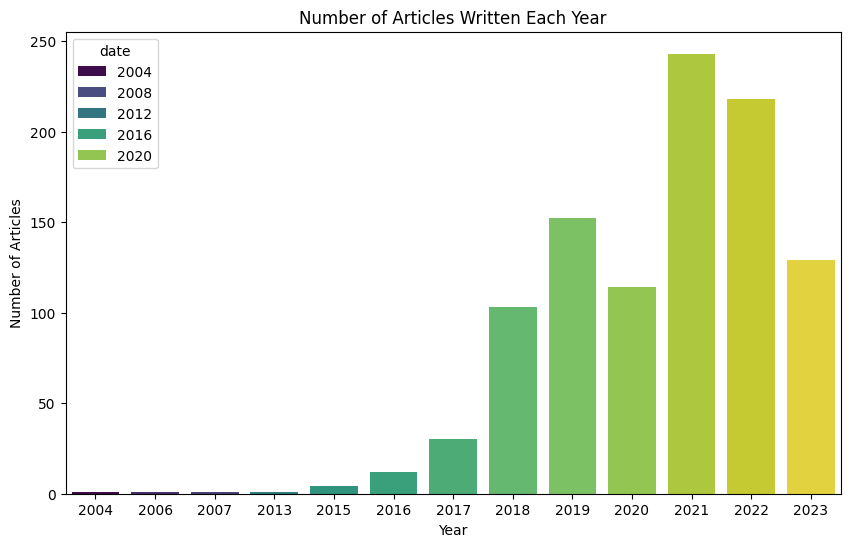

In [13]:
df_grouped = df.groupby(df['date'].dt.year).count()
plt.figure(figsize=(10, 6))
sns.barplot(x=df_grouped.index, y=df_grouped.main_text, palette="viridis", hue=df_grouped.index)
plt.title("Number of Articles Written Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.show()

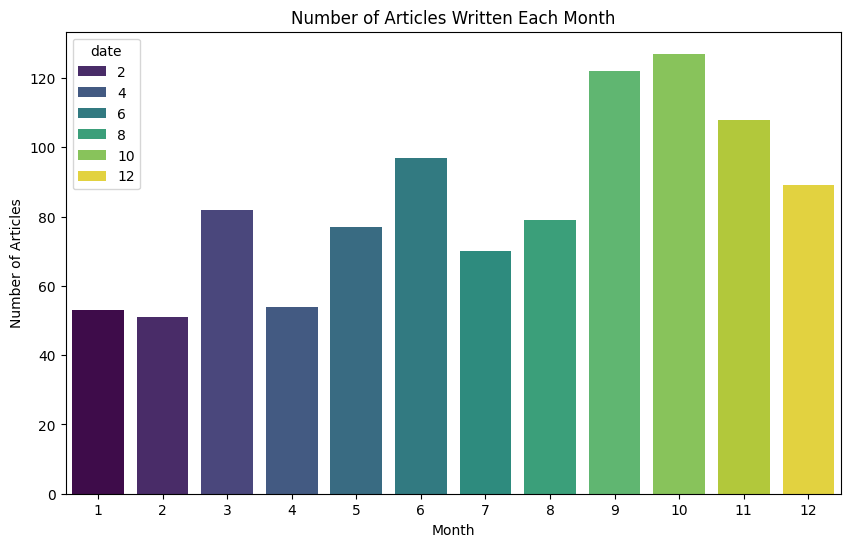

In [14]:
df_grouped = df.groupby(df['date'].dt.month).count()
plt.figure(figsize=(10, 6))
sns.barplot(x=df_grouped.index, y=df_grouped.main_text, palette="viridis", hue=df_grouped.index)
plt.title("Number of Articles Written Each Month")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.show()

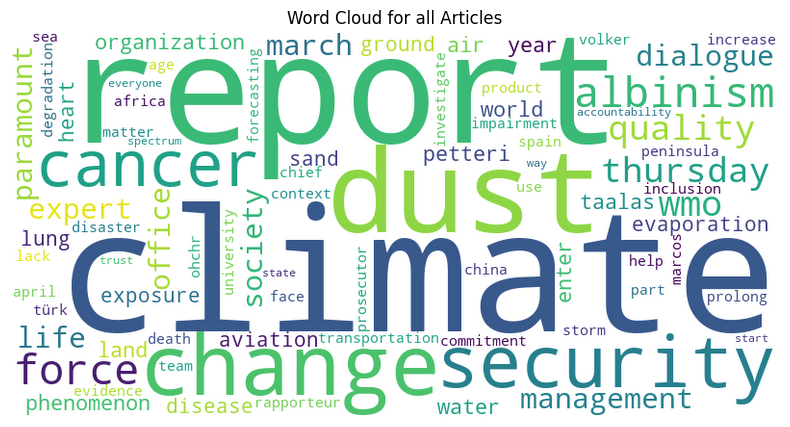

In [15]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    words = [word for (word, pos) in nltk.pos_tag(words) if pos=="NN"]
    return words

df['new_main_text'] = df['main_text'].apply(preprocess_text)
#df['new_summary'] = df['summary'].apply(preprocess_text)

text = ' '.join(df['new_main_text'].iloc[0])
for art in range(1,len(df["new_main_text"])):
    try:
        line = ' '.join(art)
        text = text + ' ' + line
    except:
        pass
    
    
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='lanczos')
plt.title('Word Cloud for all Articles')
plt.axis("off")
plt.show()

PREPROCESSING

In [6]:
def split_main_text(main_text):
    if pd.notna(main_text):
        main_text_list = main_text.split('\a')
        return main_text_list
    else:
        return []
    
def concat_cols(line):
    try:
        text = line["title"] + " " + line["date"] + " " + line["category"] + " " + line["headers"] + " " + line["main_text_splitted"]
    except:
        text = line["title"] + " " + line["date"] + " " + line["category"] + " " + line["main_text_splitted"]
    return text

def clean_text(text):
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-printable characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text



In [4]:
df = pd.read_csv("../files/articles_V2.csv")

<Axes: xlabel='main_text_len'>

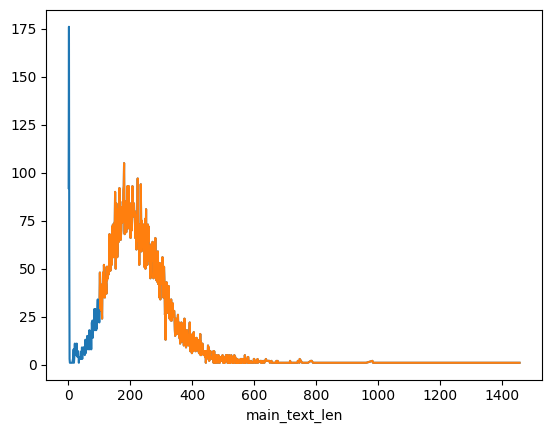

In [7]:
df['main_text_splitted'] = df['main_text'].apply(lambda x: split_main_text(x))
df = df.drop(['summary', 'main_text'], axis=1)
df = df[df['category'] == "Climate and Environment"]
df = df.reset_index(drop=True)
df = df.explode('main_text_splitted')
df.reset_index(drop=True, inplace=True)
ind = df[df["main_text_splitted"].isnull()].index
df = df.drop(ind, axis=0)
df.reset_index(drop=True, inplace=True)
df["main_text_len"] = df["main_text_splitted"].apply(lambda x: len(x))
df.groupby(by="main_text_len").count()["main_text_splitted"].plot()
df = df[(df["main_text_len"]) > 100]
df.reset_index(drop=True, inplace=True)
df.groupby(by="main_text_len").count()["main_text_splitted"].plot()

In [8]:
df["text"] = df.apply(lambda x: concat_cols(x), axis=1)
df = df.drop(["date","category","headers", "main_text_splitted", "main_text_len"], axis=1)
df.reset_index(drop=True, inplace=True)
df['text'] = df['text'].apply(clean_text)
df.to_csv('../files/preprocessed_articles.csv', index=False)

EMBEDDINGS BERT

In [ ]:
df = pd.read_csv("../files/preprocessed_articles.csv")
paragraphs = list(df["text"])

model_bert = SentenceTransformer('bert-base-nli-max-tokens')

embedding_bert = np.array(model_bert.encode(paragraphs, show_progress_bar=True))

#Bert embeddings are shape of 768
print("Bert Embedding shape", embedding_bert.shape)
print("Bert Embedding sample", embedding_bert[0][0:50])

with open('../files/embeddings.pickle.pkl', 'wb') as f:
    pkl.dump(embedding_bert, f)

EMBEDDINGS SENT2VEC

In [11]:
def cleantxt(text):
    text = text.replace('\r', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()
    text = ''.join([wrd.lower() for wrd in text if wrd not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [wrd for wrd in tokens if wrd not in stopwords]
    tokens = [wn.lemmatize(wrd) for wrd in tokens]
    return tokens

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [12]:
df = pd.read_csv("../files/preprocessed_articles.csv")
sents = list(df["text"])
sent_tokens = [cleantxt(sent) for sent in sents]
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(sent_tokens)]


In [13]:
## Train doc2vec model
model = Doc2Vec(tagged_data,
                 vector_size = 20,
                 window = 2,
                 min_count = 1,
                 epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

'\nvector_size = Dimensionality of the feature vectors.\nwindow = The maximum distance between the current and predicted word within a sentence.\nmin_count = Ignores all words with total frequency lower than this.\nalpha = The initial learning rate.\n'

In [14]:
embeddings_sent2vec = model.wv.vectors
embeddings_rows = model.wv.vectors.shape[0]
embeddings_cols = model.wv.vectors.shape[1]

with open(f'../files/embeddings_sent2vec_{embeddings_rows}_{embeddings_cols}.pkl', 'wb') as f:
    pkl.dump(model, f)

PROMTING BERT SIMILARITIES

In [18]:
df = pd.read_csv("../files/preprocessed_articles.csv")
with open('../files/embeddings.pickle.pkl', 'rb') as f:
    embedding_bert = pkl.load(f)

query = input("Enter your query: ")

model_bert = SentenceTransformer('bert-base-nli-max-tokens')
query_embedding_bert = np.array(model_bert.encode([query]
                                                  ,show_progress_bar=True
                                ))
cosine_similarities = cosine_similarity(query_embedding_bert, embedding_bert)

df["cosine_similarities"] = pd.DataFrame(cosine_similarities).T
temp_df = df.sort_values(by= "cosine_similarities", ascending=False).head(10)
temp_df.reset_index(drop=True, inplace=True)

print(temp_df["text"][0])

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

at un st vincent and grenadines prime minister eschews illiberal intolerance calls for global cooperation multilateralism 27 september 2018 climate and environment summary of statement available here ours is a flame of respect mr gonsalves said concluding for sovereignty for diversity of views for dialogue for peace and for development


PROMTING SEC2VEC SIMILARITIES

In [20]:
def cleantxt(text):
    text = text.replace('\r', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()
    text = ''.join([wrd.lower() for wrd in text if wrd not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [wrd for wrd in tokens if wrd not in stopwords]
    tokens = [wn.lemmatize(wrd) for wrd in tokens]
    return tokens

df = pd.read_csv("../files/preprocessed_articles.csv")
with open(f'../files/embeddings_sent2vec_23779_20.pkl', 'rb') as f:
    model = pkl.load(f)

embeddings_rows = model.wv.vectors.shape[0]
embeddings_cols = model.wv.vectors.shape[1]

new_sent = input("Enter your query: ")
test_doc = cleantxt(new_sent)
test_doc_vector = model.infer_vector(test_doc)
text_ind = model.dv.most_similar(positive = [test_doc_vector])[0][0]

print(df['text'][text_ind])

first person owner of first vegan football club scoring sustainable goals 10 june 2021 climate and environment mistake to talk about making financial sense  example to others if you go back ten years it was more expensive to be environmentally friendly than it is today solar panels were pricey and electric cars barely existed even plantbased food which should be cheaper than meat was more expensive 


POSTGRES DB CONNECTION

In [7]:
np.random.uniform(0, 1, 1)[0]

0.4754366035540405

In [3]:
sleep(np.random.uniform(3, 4, 1)[0])

In [12]:
try:
    conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="Climate_Change_DB",
    user="postgres",
    password="212121fg!"
    )   
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    if cursor.fetchone()[0] == 1:
        print("Connection to PostgreSQL successful")
    conn.close()
except Exception as e:
    print("Error connecting to PostgreSQL:", e)

Connection to PostgreSQL successful


In [21]:
conn = psycopg2.connect(
    host="localhost",
    port=5434,
    database="Climate_Change_DB",
    user="postgres",
    password="212121fg!"
)
cursor = conn.cursor()

In [7]:
conn.status

1

In [6]:
df = pd.read_csv('../files/articles_V2.csv')
df_dict = df.to_dict('records')

In [16]:
#Create a table if doesn't exist

create_table_query = """
CREATE TABLE IF NOT EXISTS articles (
    id INTEGER PRIMARY KEY,
    link TEXT,
    title TEXT,
    date TIMESTAMP,
    category TEXT,
    main_text TEXT,
    headers TEXT
);
"""

cursor.execute(create_table_query)
conn.commit()
cursor.close()
conn.close()

In [52]:
link = "https://news.un.org//en/story/2023/10/1142562"
df = pd.read_sql_query("""
SELECT count(*)
FROM articles
where link = %s 
""", conn, params=[link])

C:\Users\Intel PC G5900\AppData\Local\Temp\ipykernel_5716\2671667975.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("""


In [56]:
df['count'][0]

1

In [ ]:
conn.commit()
cursor.close()
conn.close()

In [41]:
for item in df_dict:
    id  = item["link"].split('/')[-1].split('-')[0]
    link = item["link"]
    title = item["title"]

    date_str = item['date']
    date = datetime.datetime.strptime(date_str, "%d %B %Y")
    formatted_date = date.strftime("%d/%m/%Y")
    date = formatted_date

    category = item["category"]
    main_text = item["main_text"]
    headers = item["headers"]

    insert_query = f"INSERT INTO articles (id, link, title, date, category, main_text, headers) VALUES (%s, %s, %s, %s, %s, %s, %s)"
    values = (id, link, title, date, category, main_text, headers)

    cursor.execute(insert_query, values)
    conn.commit()

cursor.close()
conn.close()

In [30]:
temp_dict = {
    'title': 'arterr',
    'date' : 'sfgjfgh',
    'category' : 'srqaera',
    'summary' : 'mnmnm',
    'main_text': 'qowedfkwejffo'
}

In [25]:
main_dict = {}

In [34]:
main_dict.update(temp_dict)

In [35]:
main_dict

{'title': 'arterr',
 'date': 'sfgjfgh',
 'category': 'srqaera',
 'summary': 'mnmnm',
 'main_text': 'qowedfkwejffo'}

In [2]:
date_str = "12 October 2023"
parsed_date = dateutil.parser.parse(date_str)
formatted_date = parsed_date.strftime("%d/%m/%Y")
print(formatted_date)  # Output: 08/09/2023

12/10/2023
